In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y_true = mnist.data, mnist.target.astype(int)
X = X/255.0

In [11]:
kmeans = KMeans(n_clusters=20, random_state=42)
cluster_labels = kmeans.fit_predict(X)

In [13]:
plt.figure(figsize=(15, 5))
centroids = kmeans.cluster_centers_.reshape(20, 28, 28)

<Figure size 1500x500 with 0 Axes>

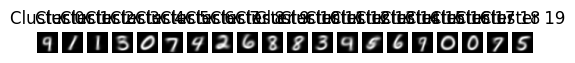

In [27]:
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(centroids[i], cmap='gray')
    plt.title(f'Cluster {i}')
    plt.axis('off')

In [28]:
cluster_to_digit = {
    0: 9,  # Example mapping - adjust based on your observation
    1: 1,
    2: 1,
    3: 8,
    4: 0,
    5: 7,
    6: 9,
    7: 2,
    8: 6,
    9: 8,
    10: 8,
    11: 3,
    12: 9,
    13: 5,
    14: 6,
    15: 9,
    16: 0,
    17: 0,
    18: 7,
    19: 5
}

In [29]:
y_propagated = np.array([cluster_to_digit[label] for label in cluster_labels])

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, kmeans, cluster_map):
        self.kmeans = kmeans
        self.cluster_map = cluster_map
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        clusters = self.kmeans.predict(X)
        return np.array([self.cluster_map[c] for c in clusters]).reshape(-1, 1)
    

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor

def create_model():
    model = Sequential(
    [
        Dense(128, activation='relu', input_shape=(794,)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ]
    )
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model
    

In [39]:
preprocessor = ColumnTransformer([
    ('features', 'passthrough', list(range(784))),
    ('cluster_labels', OneHotEncoder(categories=[range(20)]), [784])
], remainder='drop')

# Full prediction pipeline
full_pipeline = Pipeline([
    ('cluster_labeler', ClusterLabeler(kmeans, cluster_to_digit)),
    ('append_features', ColumnTransformer([
        ('original', 'passthrough', list(range(784))),
        ('cluster_label', OneHotEncoder(), [0])
    ])),
    ('classifier', KerasClassifier(model=create_model, 
                                       epochs=10,
                                       batch_size=32,
                                       verbose=1))
])

# Split data (use propagated labels for training)
X_train, X_test, y_prop_train, y_prop_test, y_true_train, y_true_test = train_test_split(
    X, y_propagated, y_true, test_size=0.2, random_state=42
)

# Train pipeline
full_pipeline.fit(X_train, y_prop_train)

# Evaluate on true labels
from sklearn.metrics import accuracy_score

y_pred = full_pipeline.predict(X_test)
print(f"Accuracy against true labels: {accuracy_score(y_true_test, y_pred):.4f}")


ValueError: all features must be in [0, 0] or [-1, 0]